In [2]:
import pandas as pd

In [3]:
original_data = pd.read_csv("./Datasets/bank.csv")
dp_data = pd.read_csv("./Datasets/dp_anonymized_data.csv")
k_anon_data = pd.read_csv("./Datasets/k_anonymized_5.csv")
l_div_data = pd.read_csv("./Datasets/l_diversified_data.csv")

print("Datasets loaded successfully.")
print(f"Original data shape: {original_data.shape}")
print(f"DP data shape: {dp_data.shape}")
print(f"K-Anonymity data shape: {k_anon_data.shape}")
print(f"L-Diversity data shape: {l_div_data.shape}")

Datasets loaded successfully.
Original data shape: (11162, 17)
DP data shape: (11162, 17)
K-Anonymity data shape: (11162, 17)
L-Diversity data shape: (11162, 18)


In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Identify categorical and numeric columns
categorical_cols = X_orig_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_orig_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Define models with pipelines
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier())
    ])
}


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score



results = {}

for name, model in models.items():
    # Train and evaluate on original data
    model.fit(X_orig_train, y_train)
    y_pred_orig = model.predict(X_orig_test)
    y_proba_orig = model.predict_proba(X_orig_test)[:, 1]

    acc_orig = accuracy_score(y_test, y_pred_orig)
    auc_orig = roc_auc_score(y_test, y_proba_orig)

    # Train and evaluate on DP data
    model.fit(X_dp_train, y_train)
    y_pred_dp = model.predict(X_dp_test)
    y_proba_dp = model.predict_proba(X_dp_test)[:, 1]

    acc_dp = accuracy_score(y_test, y_pred_dp)
    auc_dp = roc_auc_score(y_test, y_proba_dp)

    results[name] = {
        'Original': {'Accuracy': acc_orig, 'AUC': auc_orig},
        'DP': {'Accuracy': acc_dp, 'AUC': auc_dp}
    }


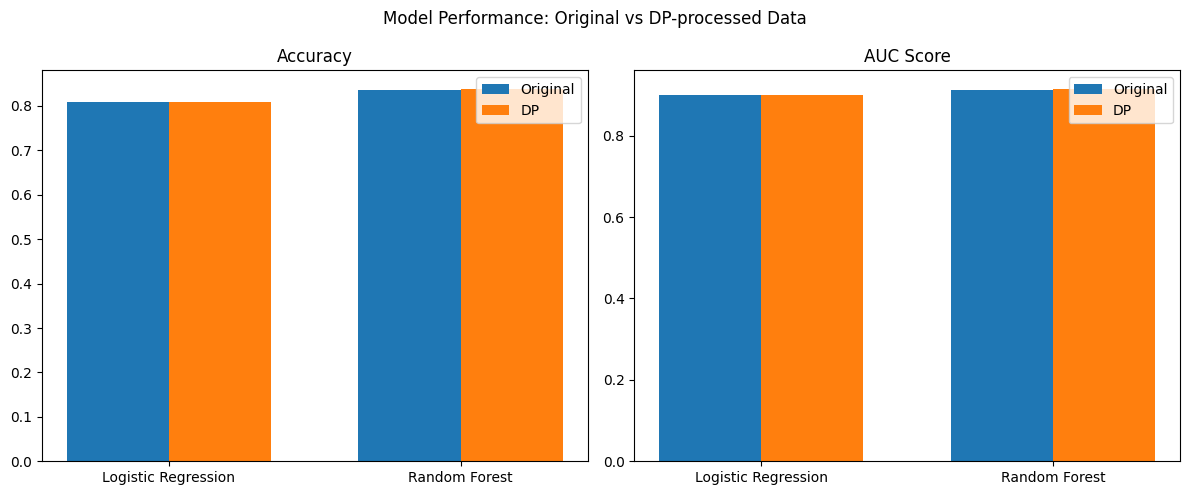

In [10]:
import matplotlib.pyplot as plt
import numpy as np

labels = list(results.keys())
accuracy_orig = [results[m]['Original']['Accuracy'] for m in labels]
accuracy_dp = [results[m]['DP']['Accuracy'] for m in labels]
auc_orig = [results[m]['Original']['AUC'] for m in labels]
auc_dp = [results[m]['DP']['AUC'] for m in labels]

x = np.arange(len(labels))  # model names
width = 0.35

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy Plot
ax[0].bar(x - width/2, accuracy_orig, width, label='Original')
ax[0].bar(x + width/2, accuracy_dp, width, label='DP')
ax[0].set_title('Accuracy')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

# AUC Plot
ax[1].bar(x - width/2, auc_orig, width, label='Original')
ax[1].bar(x + width/2, auc_dp, width, label='DP')
ax[1].set_title('AUC Score')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

plt.suptitle("Model Performance: Original vs DP-processed Data")
plt.tight_layout()
plt.show()


p =  0.731058578630005


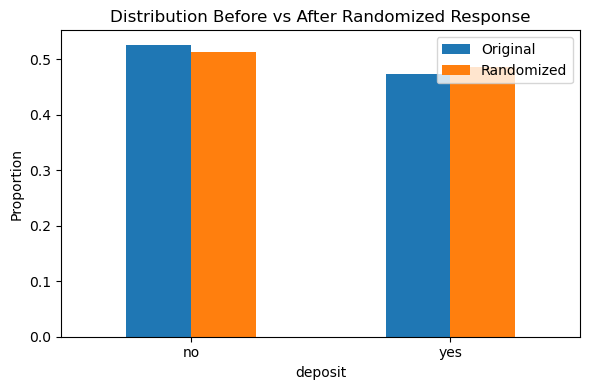


Value distributions (proportions):

         Original  Randomized
deposit                      
no         0.5262      0.5140
yes        0.4738      0.4860


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class RandomizedResponder:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def apply(self, df, column):
        if column not in df.columns:
            raise ValueError(f"Column '{column}' not found.")

        values = df[column].value_counts().index.tolist()
        k = len(values)
        p = np.exp(self.epsilon) / (np.exp(self.epsilon) + k - 1)
        print("p = ", p)        
        original_values = df[column].values
        randomized_values = []

        for val in original_values:
            if np.random.rand() < p:
                randomized_values.append(val)
            else:
                other_values = [v for v in values if v != val]
                randomized_values.append(np.random.choice(other_values))

        df_randomized = df.copy()
        df_randomized[column] = randomized_values
        return df_randomized

original_data = pd.read_csv("./data/bank.csv")

# Apply Randomized Response
rr = RandomizedResponder(epsilon=1.0)
randomized_data = rr.apply(original_data, "deposit")

# Plot original vs randomized distribution
orig_counts = original_data["deposit"].value_counts(normalize=True)
rand_counts = randomized_data["deposit"].value_counts(normalize=True)

df_plot = pd.DataFrame({
    "Original": orig_counts,
    "Randomized": rand_counts
})

df_plot.plot(kind="bar", figsize=(6,4), title="Distribution Before vs After Randomized Response")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the proportions as numbers
print("\nValue distributions (proportions):\n")
print(df_plot.to_string(float_format="%.4f"))